In [2]:
include("F:/Tue/Thesis/codes/GP_CVI/BayesianUtilities-main/BayesianUtilities-main/BayesianUtilities.jl")
using Distributions, LinearAlgebra, Plots, Random, .BayesianUtilities, Zygote
using DataStructures: Queue, enqueue!, dequeue!
using CSV, DataFrames

In [6]:
include("F:/Tue/Thesis/codes/GP_CVI/normal GP.jl") # remember to change the path 
include("F:/Tue/Thesis/codes/GP_CVI/optimize_normal_GP.jl") # remember to change the path

optim_gp (generic function with 2 methods)

In [4]:
data = CSV.read("F:\\Tue\\Thesis\\codes\\GP_CVI\\Covid_RIVM.csv",DataFrame, delim=";");

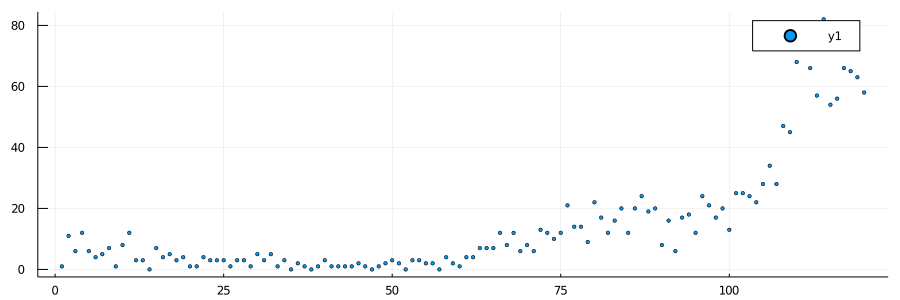

In [5]:
observation = Float64.(data.Tested_positive[1:120])
T = length(observation)
scatter(observation, markersize=2, size = (900, 300))

# Model Specification

In [7]:
# Newtonian dynamics assumption
A = [1. 1.; 0. 1.]
B = [1. 0.]

# Priors
p_z_init = MvNormal(zeros(2),diagm(0=>ones(2)))
#p_W = Wishart(2,diagm(0=>ones(2)))
W = diagm(0=>ones(2))

# Non-conjugate loglikelihood function
function log_likelihood(y,z)
    x = exp((B*z)[1]) # B*z returns 1 dimensional array
    logpdf(Poisson(x),y)
end

log_likelihood (generic function with 1 method)

# Inference

In [8]:
# CVI message towards z
function approx_message_z(obs::Real,mes_income::MvNormal,η::Real,n_its::Int)
    q = mes_income # initialize variational distribution with closed form incoming message
    _, _, λ_q, _, _ = exp_family(q) # initial variational parameters
    λ_m = zeros(6) # initial message parameters
    optimizer = ConvexAdam(η, 6) # initialize optimizer as convex combination Adam
    violation = 0 # keep track of number of updates lead to invalid parameters 
    λ_m_latest = Queue{Vector}()
    for n=1:n_its
        logp(z) = log_likelihood(obs,z)
        grad = cvi(logp,q) # grad estimates
        λ_m_old = λ_m # to check the convergence
        #λ_m = opt_step!(optimizer, λ_m, grad) # update message parameters
        λ_m = (1 .- η).*λ_m .+ η .* grad
        λ_q = λ_q .+ λ_m # update variational parameters
        try
            q = exp_family(MvNormal, λ_q) # update q
            enqueue!(λ_m_latest, λ_m_old)
            if n>9
                λ_m_average = sum(λ for λ in λ_m_latest)./10
                if norm(λ_m.-λ_m_average) < 0.0001
                    println("Converged in step ",n)
                    break
                end
                dequeue!(λ_m_latest);
            end
        catch
            λ_q = λ_q .- λ_m # avoid updates that violate the support of Gaussian
            violation += 1
            @show violation
        end
    end
    return λ_m # return approximate message parameters
end

approx_message_z (generic function with 1 method)

In [9]:
function filter_GP(W, T)
    uncertainty_1 = []; #store uncertainty
    uncertainty_3 = [];
    GP_train_size = []; #store the size of training set after updating
    
    forward_estimates = Array{MvNormal}(undef, T)
    λ_m = approx_message_z(observation[1],p_z_init,0.4,200000);   
    _, _, λ_p, _, _ = exp_family(p_z_init);
    gp_input = vcat(λ_p, observation[1]); #this is our input
    gp_output = λ_m; #this is our output
    forward_estimates[1] = collide(p_z_init,Canonical(MvNormal, λ_m));
    ### Collect the first 25 samples for GP
    for t=2:25
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))));
        #start collecting data for Gp
         _, _, λ_pre, _, _ = exp_family(predict);
        temp = vcat(λ_pre,observation[t]); # use this variable to store new input
        gp_input = hcat(gp_input, temp); # collect new input data for GP
        
        λ_m = approx_message_z(observation[t],predict,0.2,200000);
        gp_output = hcat(gp_output,λ_m); # collect output for GP
        forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m));
    end
    
    ### Train GP
    #optimal parameters of the first output element
    σ1_op, l1_op,llh1 = optim_gp(gp_input, gp_output[1,:], 2., [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.], 1e-4, 1000); 
    #optimal parameters of the third output element
    σ3_op, l3_op,llh3 = optim_gp(gp_input, gp_output[3,:], 2., [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.], 1e-4, 900); 

    #@show llh1
    #@show llh3
    ### Use GP to predict the rest
    for t=26:T
        @show t
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))));
        _, _, λ_pre, _, _ = exp_family(predict);
        temp = vcat(λ_pre,observation[t]); # new point
        
        λ_m_1,var_1 = gp_predict(gp_input,gp_output[1,:],temp,σ1_op,l1_op)
        λ_m_3,var_3 = gp_predict(gp_input,gp_output[3,:],temp,σ3_op,l3_op)
        
        uncertainty_1 = append!(uncertainty_1,var_1[1])
        uncertainty_3 = append!(uncertainty_3,var_3[1])
        #check uncertainty
        
        if var_1[1] >= σ1_op && var_3[1] >= σ3_op
            λ_m = approx_message_z(observation[t],predict,0.2,200000); #use CVI
            gp_input = hcat(gp_input,temp); #observe new input
            gp_output = hcat(gp_output,λ_m); #observe new output
        else
            λ_m = [λ_m_1[1],0,λ_m_3[1],0,0,0]; #use GP's result
        end

        GP_train_size = append!(GP_train_size,size(gp_input,2))
        #@show λ_m
        forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m));
    end
    
    return forward_estimates, uncertainty_1, uncertainty_3 ,GP_train_size, σ1_op, σ3_op
end

function filter_CVI(W, T)
    forward_estimates = Array{MvNormal}(undef, T)
    λ_m = approx_message_z(observation[1],p_z_init,0.4,200000)   
    forward_estimates[1] = collide(p_z_init,Canonical(MvNormal, λ_m))
    for t=2:T
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))))
        #λ_m = approx_message_z(observation[t],predict,0.4,200000)
        λ_m = approx_message_z(observation[t],predict,0.2,200000)
        forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m))
    end
    return forward_estimates
end

function smooth(forward_estimates,W, T)
    smooth_estimates = Array{MvNormal}(undef, T)
    smooth_estimates[T] = forward_estimates[T]
    joint_dists = Array{MvNormal}(undef, T-1)
    for t=T-1:-1:1
        smooth_estimates[t], joint_dists[t] = transit(forward_estimates[t],smooth_estimates[t+1],A,W)
    end
    return smooth_estimates, joint_dists
end
;

### Use GP

In [23]:
@time begin
forward_estimates,uncer_1, uncer_3, training_size, σ1_op, σ3_op = filter_GP(W,T)
smooth_estimates_GP, joint_dists_GP = smooth(forward_estimates, W, T)
end
;

Converged in step 557
Converged in step 584
Converged in step 889
Converged in step 1773
Converged in step 926
Converged in step 1477
Converged in step 772
Converged in step 3119
Converged in step 1105
Converged in step 1506
Converged in step 575
Converged in step 2790
Converged in step 917
Converged in step 602
Converged in step 2196
Converged in step 620
Converged in step 1416
Converged in step 1235
Converged in step 995
Converged in step 326
Converged in step 600
Converged in step 918
Converged in step 658
Converged in step 460
Converged in step 644
t = 26
t = 27
t = 28
t = 29
t = 30
t = 31
t = 32
t = 33
t = 34
t = 35
t = 36
t = 37
t = 38
t = 39
t = 40
t = 41
t = 42
t = 43
t = 44
t = 45
t = 46
t = 47
t = 48
t = 49
t = 50
t = 51
t = 52
t = 53
t = 54
t = 55
t = 56
t = 57
t = 58
t = 59
t = 60
t = 61
t = 62
t = 63
t = 64
t = 65
t = 66
t = 67
t = 68
t = 69
t = 70
t = 71
t = 72
t = 73
t = 74
t = 75
Converged in step 624
t = 76
Converged in step 16303
t = 77
t = 78
t = 79
t = 80
t = 81
Con

### use CVI

In [24]:
@time begin
forward_estimates = filter_CVI(W,T)
smooth_estimates_CVI, joint_dists_CVI = smooth(forward_estimates, W, T)
end
;

Converged in step 1350
Converged in step 6687
Converged in step 1054
Converged in step 1903
Converged in step 1233
Converged in step 1517
Converged in step 1854
Converged in step 723
Converged in step 1163
Converged in step 719
Converged in step 759
Converged in step 1879
Converged in step 1754
Converged in step 510
Converged in step 87148
Converged in step 1234
Converged in step 2634
Converged in step 860
Converged in step 625
Converged in step 856
Converged in step 438
Converged in step 711
Converged in step 2199
Converged in step 1773
Converged in step 770
Converged in step 588
Converged in step 4086
Converged in step 366
Converged in step 609
Converged in step 1190
Converged in step 648
Converged in step 1657
Converged in step 1085
Converged in step 597
Converged in step 804
Converged in step 48049
Converged in step 823
Converged in step 520
Converged in step 424
Converged in step 1122
Converged in step 912
Converged in step 426
Converged in step 284
Converged in step 795
Converged

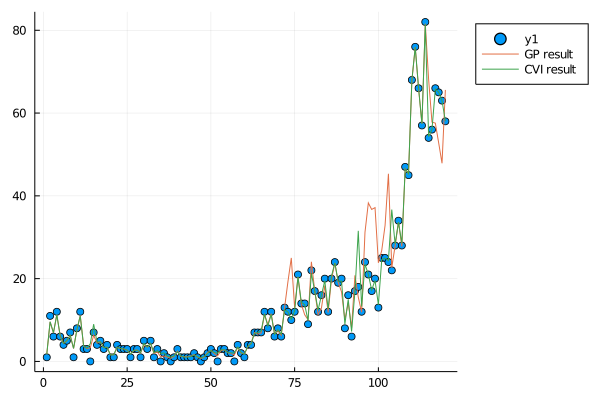

In [27]:
state1_est_GP = zeros(T)
state1_est_CVI = zeros(T)

for t=1:T
    state1_est_GP[t] = mean(smooth_estimates_GP[t])[1]
    state1_est_CVI[t] = mean(smooth_estimates_CVI[t])[1]
end

scatter(observation)
plot!(exp.(state1_est_GP),label = "GP result", legend = :outertopright)
plot!(exp.(state1_est_CVI),label = "CVI result")

In [18]:
smooth_estimates

100-element Array{MvNormal,1}:
 FullNormal(
dim: 2
μ: [0.5341363662831012, 0.6216067781558501]
Σ: [0.38679593552783376 -0.14246546006223668; -0.14246546006223668 0.44055861686671316]
)

 FullNormal(
dim: 2
μ: [2.251258254216196, 0.14769844653445607]
Σ: [0.08179067625114878 -0.024961031931129286; -0.024961031931129286 0.46516211456594087]
)

 FullNormal(
dim: 2
μ: [1.9284963464141716, 0.1442504692495426]
Σ: [0.13521054307280977 -0.03649410593690308; -0.03649410593690308 0.4660738603404265]
)

 FullNormal(
dim: 2
μ: [2.431401360241526, -0.21785205261318297]
Σ: [0.06989432253921424 -0.01799231727014231; -0.01799231727014231 0.4680116297215844]
)

 FullNormal(
dim: 2
μ: [1.8266222631979976, -0.19302753004556308]
Σ: [0.13690581536490795 -0.03274456378669272; -0.03274456378669272 0.47423925617122115]
)

 FullNormal(
dim: 2
μ: [1.4707415345584518, -0.005349808883960305]
Σ: [0.19064529116375156 -0.048212010900297114; -0.048212010900297114 0.4766724879333526]
)

 FullNormal(
dim: 2
μ: [1.619395

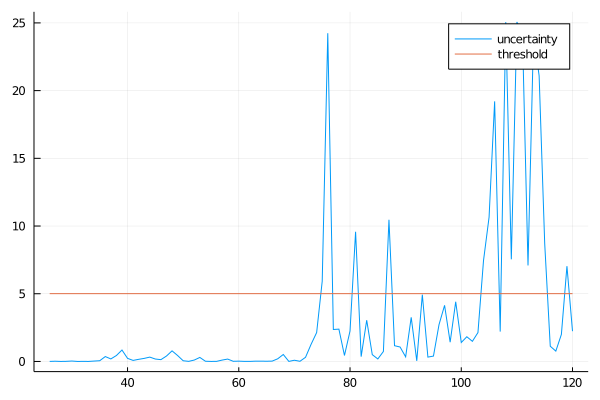

In [28]:
#plot uncertainty
plot(26:120,uncer_1, label = "uncertainty")
plot!(26:120,σ1_op.*ones(length(26:120)),label = "threshold")


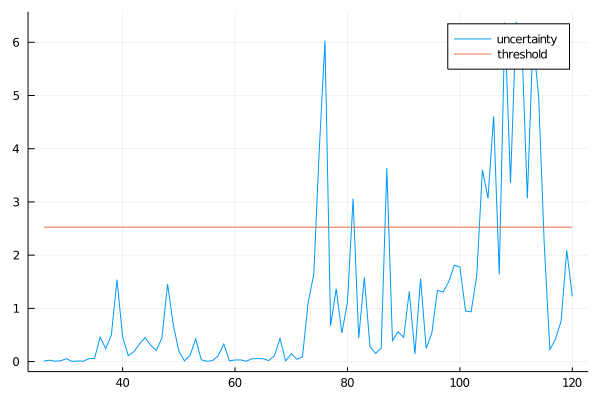

In [29]:
#plot uncertainty
plot(26:120,uncer_3,label = "uncertainty")
plot!(26:120,σ3_op.*ones(length(26:120)),label = "threshold")


In [75]:
σ1_op

5.031725979103409

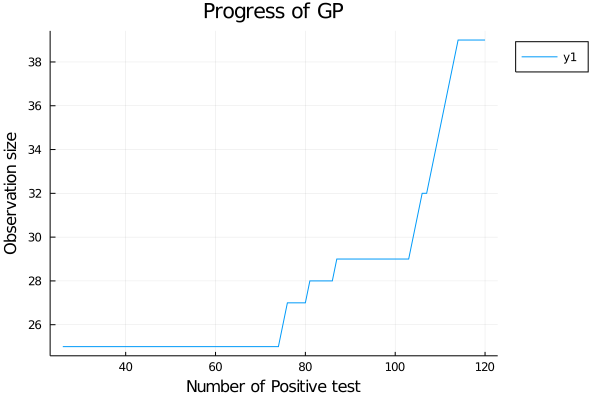

In [34]:
plot(26:120,training_size, legend = :outertopright)
xlabel!("Number of Positive test")
ylabel!("Observation size")
title!("Progress of GP")